## Pre-Processing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

filename1 = 'drive/MyDrive/TextAnalytics/training_set_1.csv'
filename2 = 'drive/MyDrive/TextAnalytics/training_set_2.csv'
filename3 = 'drive/MyDrive/TextAnalytics/test_set.csv'

Mounted at /content/drive


In [2]:
!pip install transformers 

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 44.6 MB/s 
     |████████████████████████████████| 3.3 MB 39.1 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 47.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!nvidia-smi

Thu Jan 27 09:23:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import matplotlib as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.metrics import *
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from distutils.version import LooseVersion as LV

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.10.0+cu111 Device: cuda [Tesla K80]


In [6]:
df_train1 = pd.read_csv(filename1)
df_train2 = pd.read_csv(filename2)
df_test = pd.read_csv(filename3)

df_train1.head(2)

,Unnamed: 0,review_rating,date,year,review_title,body,product_title,product_rating,language,english,pos_review,body_tok,body_tok_ngrams,body_lem_ngrams
0,27931,2,"September 13, 2018",2018,Bad battery,I’m happy with the way the phone looks but upo...,"Apple iPhone 6S, 64GB, Rose Gold - For AT&T / ...",3.6,en,1,0,"['happy', 'way', 'phone', 'looks', 'upon', 'op...","['happy', 'way', 'phone', 'looks', 'upon', 'op...","['LEM_happy', 'LEM_way', 'LEM_phone', 'LEM_loo..."
1,18619,1,"June 18, 2018",2018,Very bad experience and Amazon didn't help me ...,the brand itself is not a problem. the problem...,Samsung Galaxy S7 SM-G930A AT&T Unlocked Smart...,3.1,en,1,0,"['brand', 'problem', 'problem', 'seller', 'pho...","['brand', 'problem', 'problem', 'seller', 'pho...","['LEM_brand', 'LEM_problem', 'LEM_problem', 'L..."


In [7]:
# Usiamo il TRAINING SET 2

train = df_train2[['body_tok', 'pos_review']]

test = df_test[['body_tok', 'pos_review']]

train.head(2)

,body_tok,pos_review
0,"['getting', 'hot', '1', 'hour', 'use', 'though...",0
1,"['would', 'charge', ['B_would_charge']]",0


In [8]:
# Preparazione due training set
X_train = train['body_tok']

y_train = train['pos_review']


# Preparazione test set
X_test = test['body_tok']
y_test = test['pos_review']

len(X_train),len(y_train),len(X_test),len(y_test)

(10000, 10000, 20000, 20000)

In [9]:
# Per Evaluation

def model_evaluation(real_v, pred_v):
    print(f"Accuracy sore: {accuracy_score(real_v, pred_v)}")
    print("Classification report:")
    print(classification_report(real_v, pred_v))
    cm = confusion_matrix(real_v, pred_v)
    print (f"Confusion matrix \n {cm}")

In [10]:
# Transform target in tensors
train_labels = torch.tensor(y_train)

test_labels = torch.tensor(y_test)

## BERT Tokenizer
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start. 
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
Function *tokenizer.encode_plus* was used which encapsulates the whole procedure

In [11]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# Example 
print("Tokenized review: ", tokenizer.tokenize(X_train.values[0]))
print("Original review: ", X_train.values[0])

Tokenized review:  ['[', "'", 'getting', "'", ',', "'", 'hot', "'", ',', "'", '1', "'", ',', "'", 'hour', "'", ',', "'", 'use', "'", ',', "'", 'though', "'", ',', "'", 'return', "'", ',', "'", 'getting', "'", ',', "'", 'full', "'", ',', "'", 'ref', '##und', "'", ',', '[', "'", 'b', '_', 'getting', '_', 'hot', "'", ',', "'", 'b', '_', 'hot', '_', '1', "'", ',', "'", 'b', '_', '1', '_', 'hour', "'", ',', "'", 'b', '_', 'hour', '_', 'use', "'", ',', "'", 'b', '_', 'use', '_', 'though', "'", ',', "'", 'b', '_', 'though', '_', 'return', "'", ',', "'", 'b', '_', 'return', '_', 'getting', "'", ',', "'", 'b', '_', 'getting', '_', 'full', "'", ',', "'", 'b', '_', 'full', '_', 'ref', '##und', "'", ',', "'", 't', '_', 'getting', '_', 'hot', '_', '1', "'", ',', "'", 't', '_', 'hot', '_', '1', '_', 'hour', "'", ',', "'", 't', '_', '1', '_', 'hour', '_', 'use', "'", ',', "'", 't', '_', 'hour', '_', 'use', '_', 'though', "'", ',', "'", 't', '_', 'use', '_', 'though', '_', 'return', "'", ',', "'", 't'

In [13]:
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_train.values[0])))

Token IDs:  [1031, 1005, 2893, 1005, 1010, 1005, 2980, 1005, 1010, 1005, 1015, 1005, 1010, 1005, 3178, 1005, 1010, 1005, 2224, 1005, 1010, 1005, 2295, 1005, 1010, 1005, 2709, 1005, 1010, 1005, 2893, 1005, 1010, 1005, 2440, 1005, 1010, 1005, 25416, 8630, 1005, 1010, 1031, 1005, 1038, 1035, 2893, 1035, 2980, 1005, 1010, 1005, 1038, 1035, 2980, 1035, 1015, 1005, 1010, 1005, 1038, 1035, 1015, 1035, 3178, 1005, 1010, 1005, 1038, 1035, 3178, 1035, 2224, 1005, 1010, 1005, 1038, 1035, 2224, 1035, 2295, 1005, 1010, 1005, 1038, 1035, 2295, 1035, 2709, 1005, 1010, 1005, 1038, 1035, 2709, 1035, 2893, 1005, 1010, 1005, 1038, 1035, 2893, 1035, 2440, 1005, 1010, 1005, 1038, 1035, 2440, 1035, 25416, 8630, 1005, 1010, 1005, 1056, 1035, 2893, 1035, 2980, 1035, 1015, 1005, 1010, 1005, 1056, 1035, 2980, 1035, 1015, 1035, 3178, 1005, 1010, 1005, 1056, 1035, 1015, 1035, 3178, 1035, 2224, 1005, 1010, 1005, 1056, 1035, 3178, 1035, 2224, 1035, 2295, 1005, 1010, 1005, 1056, 1035, 2224, 1035, 2295, 1035, 2709, 1

In [14]:
# Example complete:
sentence = X_train.values[0]
tokens_ = tokenizer.tokenize(sentence)
tokens_ = ['[CLS]'] + tokens_ + ['[SEP]']
print("Tokenized review: ", tokens_)
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokens_))

Tokenized review:  ['[CLS]', '[', "'", 'getting', "'", ',', "'", 'hot', "'", ',', "'", '1', "'", ',', "'", 'hour', "'", ',', "'", 'use', "'", ',', "'", 'though', "'", ',', "'", 'return', "'", ',', "'", 'getting', "'", ',', "'", 'full', "'", ',', "'", 'ref', '##und', "'", ',', '[', "'", 'b', '_', 'getting', '_', 'hot', "'", ',', "'", 'b', '_', 'hot', '_', '1', "'", ',', "'", 'b', '_', '1', '_', 'hour', "'", ',', "'", 'b', '_', 'hour', '_', 'use', "'", ',', "'", 'b', '_', 'use', '_', 'though', "'", ',', "'", 'b', '_', 'though', '_', 'return', "'", ',', "'", 'b', '_', 'return', '_', 'getting', "'", ',', "'", 'b', '_', 'getting', '_', 'full', "'", ',', "'", 'b', '_', 'full', '_', 'ref', '##und', "'", ',', "'", 't', '_', 'getting', '_', 'hot', '_', '1', "'", ',', "'", 't', '_', 'hot', '_', '1', '_', 'hour', "'", ',', "'", 't', '_', '1', '_', 'hour', '_', 'use', "'", ',', "'", 't', '_', 'hour', '_', 'use', '_', 'though', "'", ',', "'", 't', '_', 'use', '_', 'though', '_', 'return', "'", ',',

### MAX_LENGTH

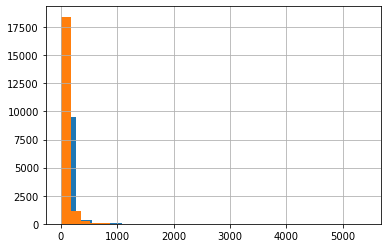

In [15]:
train = [len(i.split()) for i in X_train]

test = [len(i.split()) for i in X_test]

for i in [train, test]:
  pd.Series(i).hist(bins=20)

In [16]:
MAX_LENGTH = 25

### Aggiungiamo i separatori, convertiamo i token in *integer index*, creiamo le *attention mask*

In [17]:
def prepare_data(data, max_len):
  inputs_ = []
  attention_mask = []
  for review in data:
    encoded_dict = tokenizer.encode_plus(
      review, #review to encode = (tokenize + add special character)
      add_special_tokens = True, # Add [CLS] for specify classification task and [SEP]
      max_length = max_len,
      pad_to_max_length  = True, #For pad & truncate all sentence
      return_attention_mask = True, # For return attention masks
      #return_tensors = 'pt' # Return pythorch tensors
    )
    # Select encoded sentence    
    inputs_.append(encoded_dict['input_ids'])

    # Select attention masks
    attention_mask.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.tensor(inputs_)
  attention_masks = torch.tensor(attention_mask)

  return input_ids, attention_masks

In [18]:
train_data, train_masks = prepare_data(X_train, MAX_LENGTH)
test_data, test_masks = prepare_data(X_test, MAX_LENGTH)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
# Print sentence 0, now as a list of IDs.
print('Original: ', X_train.values[0])
print('Token IDs:', train_data[0])
print('Attention Mask:', train_masks[0])

Original:  ['getting', 'hot', '1', 'hour', 'use', 'though', 'return', 'getting', 'full', 'refund', ['B_getting_hot', 'B_hot_1', 'B_1_hour', 'B_hour_use', 'B_use_though', 'B_though_return', 'B_return_getting', 'B_getting_full', 'B_full_refund', 'T_getting_hot_1', 'T_hot_1_hour', 'T_1_hour_use', 'T_hour_use_though', 'T_use_though_return', 'T_though_return_getting', 'T_return_getting_full', 'T_getting_full_refund']]
Token IDs: tensor([ 101, 1031, 1005, 2893, 1005, 1010, 1005, 2980, 1005, 1010, 1005, 1015,
        1005, 1010, 1005, 3178, 1005, 1010, 1005, 2224, 1005, 1010, 1005, 2295,
         102])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])


In [20]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(train_data, train_labels,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(train_masks, train_data,
                          random_state=42, test_size=0.1)

In [21]:
# Impostiamo la dimensione dei BATCH

BATCH_SIZE = 32

### Creiamo i dataloader

In [22]:
def dataloader(input_ids, attention_masks, labels, name):
  dataset = TensorDataset(input_ids, attention_masks, labels) #Combine inputs in to a TensorDataset
  if name == "Train":
    sampler = RandomSampler(dataset)  # Select batches randomly
  else:
    sampler = SequentialSampler(dataset)  # Select batches sequentially
  data_loader = DataLoader(
            dataset,
            sampler = sampler,
            batch_size = BATCH_SIZE # Number of batchsize
  )
  print(f"{name} documents {len(dataset)}")
  return data_loader

In [23]:
train_dataloader = dataloader(train_inputs, train_masks, train_labels, "Train")
test_dataloader = dataloader(test_data, test_masks, test_labels, "Test")
val_dataloader = dataloader(validation_inputs, validation_masks, validation_labels, "Validation")

Train documents 9000
Test documents 20000
Validation documents 1000


In [24]:
# Function to calculate the accuracy of our predictions vs labels
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## BERT Initialization

Importiamo il modello pre-addestrato *bert-base-uncased*

In [25]:
BERTMODEL = "bert-base-uncased"

In [26]:
model = BertForSequenceClassification.from_pretrained(
    BERTMODEL, 
    num_labels = 2, # Binary classification   
    output_attentions = False, 
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

To run this model on the GPU

In [27]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Utilizziamo l'ottimizzazione Adam

In [28]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

In [29]:
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [30]:
# Tell PyTorch to use the GPU.    
device = torch.device("cuda")

In [31]:
training_stats = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device) #batch[0] - input_ids
        b_input_mask = batch[1].to(device) #batch[1] - attention_masks
        b_labels = batch[2].to(device) #batch[2] - labels

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs".
        model.zero_grad() 

        # Forward pass (for evaluate the model on this training batch)
        model1 = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels) 
        loss = model1.loss
        logits = model1.logits
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()       


        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)    

    print("\n \t Average training loss: {0:.2f}".format(avg_train_loss))
    
    
    # ========================================
    #               Validation PHASE 
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model2 = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = model2.loss
            logits = model2.logits
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
        }
    )


======== Epoch 1 / 2 ========
Training...

 	 Average training loss: 0.50
  Accuracy: 0.81
  Validation Loss: 0.40

======== Epoch 2 / 2 ========
Training...

 	 Average training loss: 0.39
  Accuracy: 0.82
  Validation Loss: 0.39


In [32]:
# Display floats with two decimal places.
pd.set_option('precision', 6)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.497572,0.397817,0.813477
2,0.389305,0.391728,0.818359


## Evaluation

In [33]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  prediction = np.argmax(logits, axis=1)

  # Store predictions and true labels
  for i in prediction:
    predictions.append(i)
  for i in label_ids:
    true_labels.append(i)

In [34]:
def model_evaluation(real_v, pred_v):
    print(f"Accuracy sore: {accuracy_score(real_v, pred_v)}")
    print("Classification report:")
    print(classification_report(real_v, pred_v))
    cm = confusion_matrix(real_v, pred_v)
    print (f"Confusion matrix \n {cm}")

In [35]:
model_evaluation(true_labels, predictions)

Accuracy sore: 0.81215
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70      6075
           1       0.87      0.85      0.86     13925

    accuracy                           0.81     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.81      0.81      0.81     20000

Confusion matrix 
 [[ 4338  1737]
 [ 2020 11905]]
